In [2]:
import math
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

from kneed import KneeLocator

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
matplotlib.rcParams['figure.dpi'] = 80

import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid", {'grid.linestyle': '--'})

Loading the players dataframe exported in the last part of Task 1...

In [3]:
players = pd.read_pickle('../TASK1/dataset/final_players.pkl')

---

# Clustering Analysis: K-means (part III)

The aim of this clustering is to extract from the features describing the profile of the players the most common **tennis playing styles**.

In order to do this, we exploit all the observations that we've done from the previous notebook *Clustering analysis: Hierarchical (part I)*, i.e.:

1. players of different genders and ranks will most likely have radically different features. We would like these traits to not affect the k-means clustering, as a playing styles should be independent of them. For this reason:
    * we will separately cluster male and female players
    * we will focus on players that are below a certain rank threshold

2. the hierarchical clustering highlighted the following features to be the ones that differentiate the most between different players:
    * svpt_1st_fail_ratio
    * svpt_2nd_w_ratio
    * ace_ratio
    * bp_saved_ratio
    * bp_w_ratio
    * hard_w_ratio
    
    while some of them may also hint to the players' ranking, according to the values of these features we should be able to derive different playing styles

In [4]:
FEATURE_COLS = ['ace_ratio', 'svpt_1st_fail_ratio', 'svpt_2nd_w_ratio', 'bp_saved_ratio', 'bp_w_ratio', 'hard_w_ratio', 'clay_w_ratio']
MIN_STATS_MATCH_COUNT = 20
RANK_TRESHOLDS = [200, 400, 600]

First of all, we may want to have a total mean rank of each player instead of the mean rank of each semester:

In [5]:
rank_cols = list(filter(lambda s : 'rank_sem' in s, players.columns))
players['mean_rank'] = players[rank_cols].sum(axis=1) / players[rank_cols].notna().sum(axis=1)

Let's define a convenient function to extract the players having:
* a rank less then `rank_treshold`
* at least `stats_match_count_min_threshold` number of matches
* gender `sex`

and that project along the features described by `features_cols` by applying a transformation using a scaler "`std`" (`StandardScaler`)

In [6]:
def build_clustering_data(features_cols, rank_threshold, stats_match_count_min_threshold, sex, scaler):
    
    data = players.loc[(players['mean_rank'] <= rank_threshold) & (players['stats_match_count'] >= stats_match_count_min_threshold) & (players.sex == sex), features_cols].dropna()
    
    if scaler == 'std':
        scaler = StandardScaler()
    elif scaler == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError('Invalid scaler!')
    
    data_scaled = scaler.fit_transform(data)
        
    clustering_data = {
        'original': data,
        'scaled': data_scaled,
        'scaler': scaler
    }
    
    return clustering_data

---

Let's define other functions:

* performs the k-means clustering

In [7]:
def kmeans_clustering(clustering_data, n_init, max_iter, k):
    kmeans = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter)
    kmeans.fit(clustering_data)
    return kmeans

* computes the k-means SSE curve

In [8]:
def kmeans_sse_curve(clustering_data, n_init, max_iter, max_k, verbose=False):
    sse_list = list()

    if verbose:
        print(f'Computing K-means SSE curve [n_init={n_init}, max_iter={max_iter}, max_k={max_k}]')
        
    for k in range(2, max_k + 1):
        if verbose:
            print(f'Testing k={k} ...', end='')
        kmeans = kmeans_clustering(clustering_data, n_init, max_iter, k)
        sse = kmeans.inertia_
        sse_list.append(sse)
        if verbose:
            print(f'intertia={sse}')
        
    return sse_list

* plot the k-means SSE curve

In [9]:
def kmeans_plot_sse_curve(sse_curve, ax):
    ax.plot(range(2, len(sse_curve) + 2), sse_curve, marker='+')
    ax.set_xticks(np.arange(2, len(sse_curve)+2, 2))
    ax.set_xlabel('K')
    ax.set_ylabel('SSE')

* search and draw the knee of a k-means SSE curve

In [10]:
def kmeans_plot_elbow(sse_curve, ax):
    kneedle = KneeLocator(np.arange(2, len(sse_curve)+2), sse_curve, S=0.5, curve="convex", direction="decreasing")
    ax.axvline(x=kneedle.knee, color='r', linestyle='--')

* plot the centroids of a k-means clustering

In [11]:
def kmeans_plot_centroids_hist(centroids, ax):
    for i in range(0, len(centroids)):
        ax.plot(centroids[i], marker='o', label='Centroid %s' % i)
    ax.tick_params(axis='both', which='major')
    ax.set_xlim((0, len(FEATURE_COLS)-1))
    ax.set_xticks(ax.get_xticks().tolist())
    ax.set_xticklabels(FEATURE_COLS)
    ax.set_xlim((-0.2, len(FEATURE_COLS)-0.8))

* performs the x-means clustering

In [12]:
def xmeans_clustering(clustering_data, n_trials, max_k):
    trials = list()
    
    for i in range(n_trials):
        initial_centers = kmeans_plusplus_initializer(clustering_data, 2).initialize()
        xmeans_instance = xmeans(clustering_data, initial_centers, max_k)
        xmeans_instance.process()
        trials.append({
            'clusters': xmeans_instance.get_clusters(),
            'centroids': xmeans_instance.get_centers(),
            'sse': xmeans_instance.get_total_wce()
        })
    
    return trials

* get the x-mean trial with the most common found k within a set of trials

In [13]:
def xmeans_get_common_trial(trials):
    ks_found = np.array([ len(t['clusters']) for t in trials ])
    most_common_k = np.argmax(np.bincount(ks_found))
    return trials[np.where(ks_found == most_common_k)[0][0]]

* draws the k value found by x-means on top of a k-means SSE curve

In [14]:
def plot_xmeans_best_ks(xmeans_best_k, sse_curve, ax):
    ax.plot(xmeans_best_k, sse_curve[xmeans_best_k-2], marker='X', markersize=12, color='k', alpha=0.25)

* compute and plot the silhouette coefficient of a clustering

In [15]:
def plot_silhouette(clustering_data, labels, k, ax):
    silhouette_avg = silhouette_score(clustering_data.astype('float'), labels)
    sample_silhouette_values = silhouette_samples(clustering_data.astype('float'), labels)
    y_lower = 10

    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

* for each rank treshold, perform the k-means varying the k at most to `max_k`, draw the SSE curve, find the best k according to x-means and plot the silhouette coefficients for various k

In [16]:
def kmeans_xmeans_search_k(n_init, max_iter, max_k, scaler_type, sex, silhouette_ks):
    for r in range(len(RANK_TRESHOLDS)):
        rank_threshold = RANK_TRESHOLDS[r]
            
        print(f'Threshold={rank_threshold}: ', end='')
        clustering_data = build_clustering_data(FEATURE_COLS, rank_threshold, MIN_STATS_MATCH_COUNT, sex, scaler_type)
        
        print(f'computing... ', end='')
        under_rank_sse_curve = kmeans_sse_curve(clustering_data['scaled'], n_init, max_iter, max_k)
        under_rank_xmeans_best_k = len(xmeans_get_common_trial(xmeans_clustering(clustering_data['scaled'], n_init, max_k))['clusters'])
        
        plt.figure(figsize=(5*(len(RANK_TRESHOLDS)+1), 5))
        plt.suptitle(f'[Rank < {rank_threshold}], [Scaler: {scaler_type}]')
        
        print('plotting curve... ', end='')
        ax = plt.subplot(1, 1 + len(silhouette_ks), 1)
        ax.set_title('SSE Curve')
        kmeans_plot_sse_curve(under_rank_sse_curve, ax)
        kmeans_plot_elbow(under_rank_sse_curve, ax)
        plot_xmeans_best_ks(under_rank_xmeans_best_k, under_rank_sse_curve, ax)
        
        print('plotting silhouettes... ')
        for i in range(len(silhouette_ks)):
            k = silhouette_ks[i]
            ax = plt.subplot(1, 1 + len(silhouette_ks), i+2)
            ax.set_title(f'Silhouette k={k}')
            ax.set_xlabel("silhouette coefficient values")
            ax.set_ylabel("cluster label")
            km = kmeans_clustering(clustering_data['scaled'], n_init, max_iter, k)
            plot_silhouette(clustering_data['original'], km.labels_, k, ax)
            
        plt.show()

---

## Extracting playing styles of male players

In [17]:
N_INIT = 30
MAX_ITER = 500
MAX_K = 40
SILHOUETTE_KS = [2, 4, 6]

Threshold=200: computing... plotting curve... plotting silhouettes... 


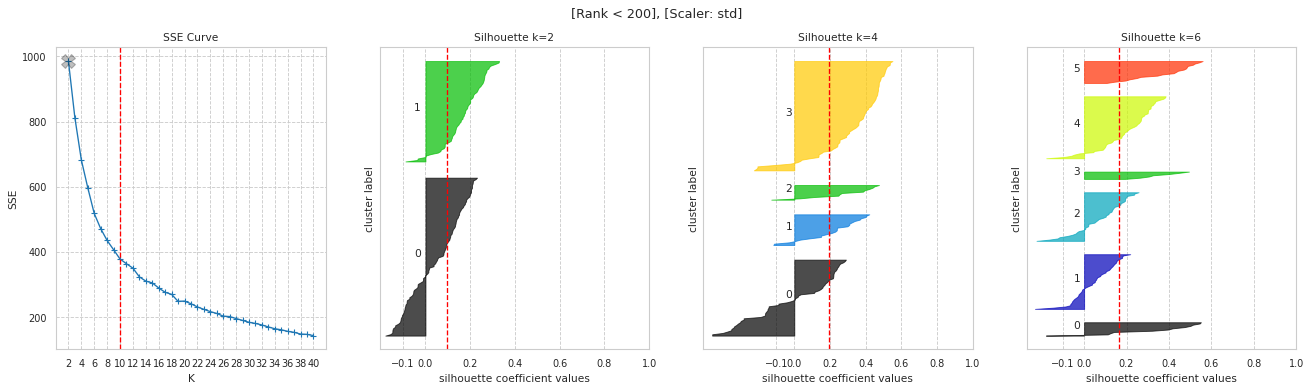

Threshold=400: computing... plotting curve... plotting silhouettes... 


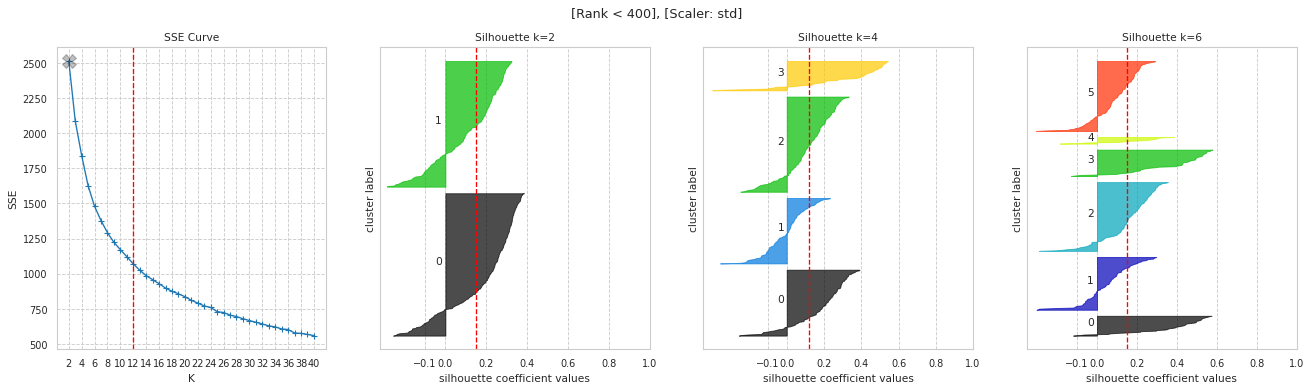

Threshold=600: computing... plotting curve... plotting silhouettes... 


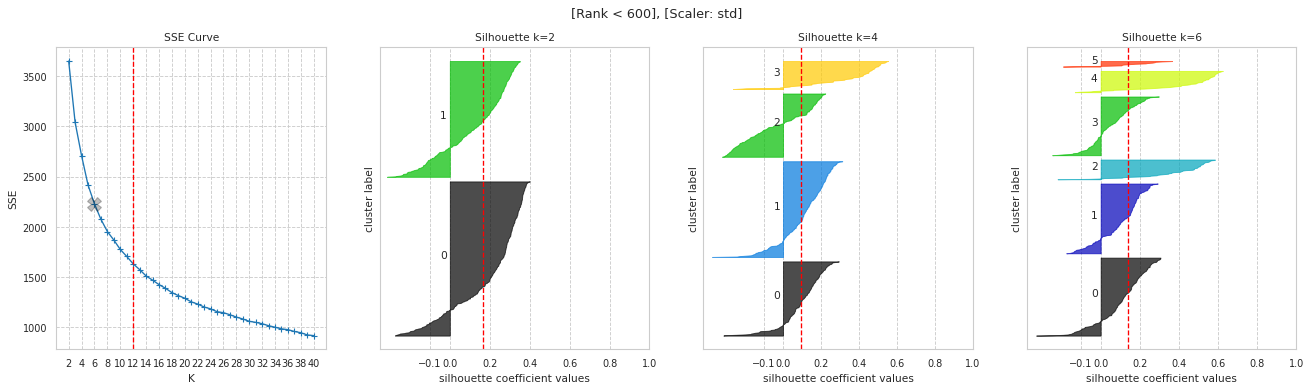

In [18]:
kmeans_xmeans_search_k(N_INIT, MAX_ITER, MAX_K, 'std', 'm', SILHOUETTE_KS)

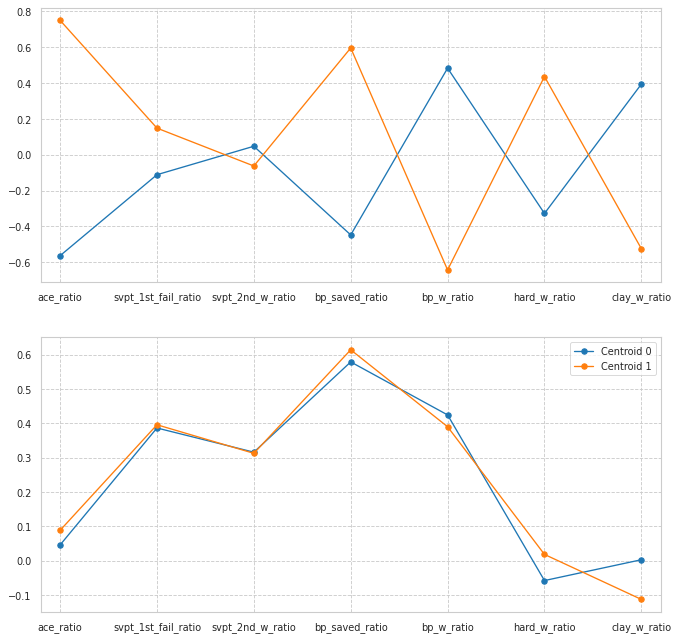

In [27]:
clustering_data = build_clustering_data(FEATURE_COLS, 600, MIN_STATS_MATCH_COUNT, 'm',  'std')
km = kmeans_clustering(clustering_data['scaled'], N_INIT, MAX_ITER, 2)

f, (a0, a1) = plt.subplots(2, 1, figsize=(10, 10))
kmeans_plot_centroids_hist(km.cluster_centers_, a0)
kmeans_plot_centroids_hist(clustering_data['scaler'].inverse_transform(km.cluster_centers_), a1)
a1.legend()

clusteringA = clustering_data['original'].copy()
clusteringA['cluster'] = km.labels_

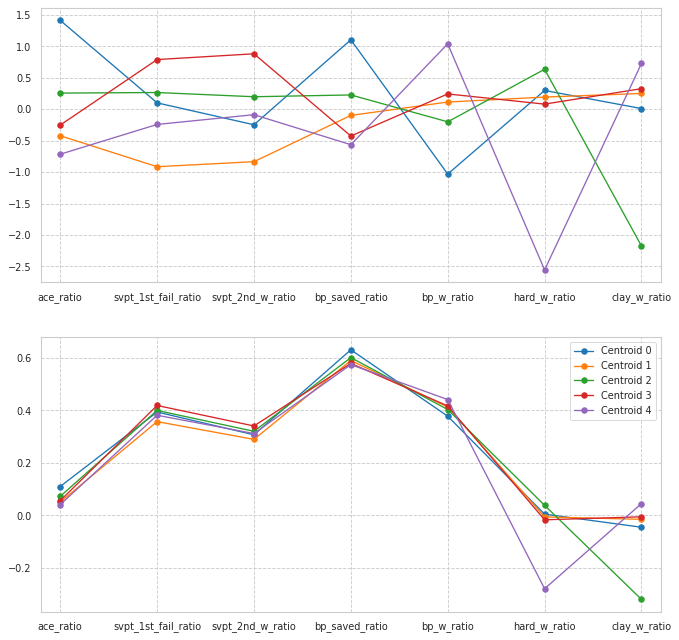

In [18]:
clustering_data = build_clustering_data(FEATURE_COLS, 600, MIN_STATS_MATCH_COUNT, 'm',  'std')
km = kmeans_clustering(clustering_data['scaled'], N_INIT, MAX_ITER, 5)

f, (a0, a1) = plt.subplots(2, 1, figsize=(10, 10))
kmeans_plot_centroids_hist(km.cluster_centers_, a0)
kmeans_plot_centroids_hist(clustering_data['scaler'].inverse_transform(km.cluster_centers_), a1)
a1.legend()

clusteringA = clustering_data['original'].copy()
clusteringA['cluster'] = km.labels_

- blu: giocatori che se la giocano più che altro nella prima di servizio facendo gli ace. Bp saved ratio più alto perché avendo l'ace dalla propria parte riescono a salvare più breakpoints. Breakpoint vinti più bassi perché sono gli avversari a servire e non loro. Più bravi sull'hard che sul clay (poiché il cemento è una superficie veloce che avvantaggia il loro stile di gioco). Es isner, anderson
- verdi: giocatori con un servizio potente (notare l'ace piuttosto elevato), forti sul cemento e probabilmente poco agili per cui non giocano bene sulla terra. Potrebbero essere come i blu, ma son meno efficiaci (infatti contengono per lo più giocatori di "seconda fascia"). Es medvedev, mannarino
- viola: giocatori tenaci (difensivi) ed agili, che sul cemento non rendono. Es cecchinato
- arancioni: giocatori equilibrati (anche per il tipo di terreno che per loro è indifferente) e killer (pochi errori in servizio), leggermente sulla difensiva/pallettari. Es djokovic, nadal
- rossi: giocatori "nervosi". Come gli arancioni, ma che nel periodo considerato non hanno giocato bene (alto tasso di errore sul servizio). Es murray, fognini

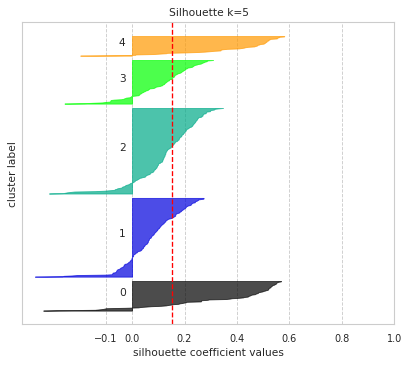

In [36]:
f, ax = plt.subplots(figsize=(6, 5))
ax.set_title(f'Silhouette k=5')
ax.set_xlabel("silhouette coefficient values")
ax.set_ylabel("cluster label")
plot_silhouette(clustering_data['original'], km.labels_, 5, ax)

In [19]:
clusteringA = clusteringA[['cluster']].join(players)

Let's see which famous players belong to each of the five clusters:

In [22]:
clusteringA.loc[clusteringA.cluster == 0, ['cluster']].join(players[['l1_f_match_count', 'l2_f_match_count']]).sort_values(by=['l1_f_match_count', 'l2_f_match_count'], ascending=False).head(10)

,cluster,l1_f_match_count,l2_f_match_count
fullname,,,
roger federer,0,12,10
dominic thiem,0,7,15
stefanos tsitsipas,0,4,12
stan wawrinka,0,3,7
marin cilic,0,3,7
john isner,0,3,6
milos raonic,0,3,5
andrey rublev,0,2,12
juan martin del potro,0,2,8


In [23]:
clusteringA.loc[clusteringA.cluster == 1, ['cluster']].join(players[['l1_f_match_count', 'l2_f_match_count']]).sort_values(by=['l1_f_match_count', 'l2_f_match_count'], ascending=False).head(10)

,cluster,l1_f_match_count,l2_f_match_count
fullname,,,
novak djokovic,1,27,8
rafael nadal,1,19,9
alexander zverev,1,10,15
kei nishikori,1,3,8
roberto bautista agut,1,1,12
diego schwartzman,1,1,10
gael monfils,1,1,8
albert ramos,1,1,8
filip krajinovic,1,1,3


In [24]:
clusteringA.loc[clusteringA.cluster == 2, ['cluster']].join(players[['l1_f_match_count', 'l2_f_match_count']]).sort_values(by=['l1_f_match_count', 'l2_f_match_count'], ascending=False).head(10)

,cluster,l1_f_match_count,l2_f_match_count
fullname,,,
daniil medvedev,2,7,12
alex de minaur,2,0,9
adrian mannarino,2,0,8
ugo humbert,2,0,3
daniel evans,2,0,3
marcos baghdatis,2,0,2
vasek pospisil,2,0,2
brandon nakashima,2,0,2
egor gerasimov,2,0,1


In [25]:
clusteringA.loc[clusteringA.cluster == 3, ['cluster']].join(players[['l1_f_match_count', 'l2_f_match_count']]).sort_values(by=['l1_f_match_count', 'l2_f_match_count'], ascending=False).head(10)

,cluster,l1_f_match_count,l2_f_match_count
fullname,,,
andy murray,3,8,7
fabio fognini,3,1,9
david goffin,3,1,7
jannik sinner,3,1,3
nikoloz basilashvili,3,0,7
cristian garin,3,0,6
pablo cuevas,3,0,6
benoit paire,3,0,5
gilles simon,3,0,4


In [26]:
clusteringA.loc[clusteringA.cluster == 4, ['cluster']].join(players[['l1_f_match_count', 'l2_f_match_count']]).sort_values(by=['l1_f_match_count', 'l2_f_match_count'], ascending=False).head(10)

,cluster,l1_f_match_count,l2_f_match_count
fullname,,,
marco cecchinato,4,0,5
laslo djere,4,0,3
juan ignacio londero,4,0,2
pablo andujar,4,0,2
federico delbonis,4,0,1
roberto carballes baena,4,0,1
facundo bagnis,4,0,1
federico coria,4,0,1
andrej martin,4,0,1


---

## Extracting playing styles of female players

Threshold=200: computing... plotting curve... plotting silhouettes... 


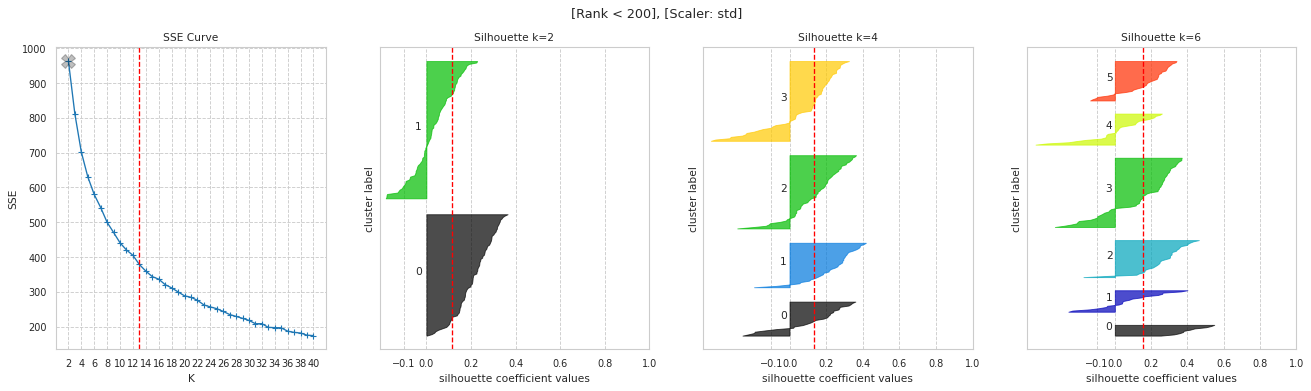

Threshold=400: computing... plotting curve... plotting silhouettes... 


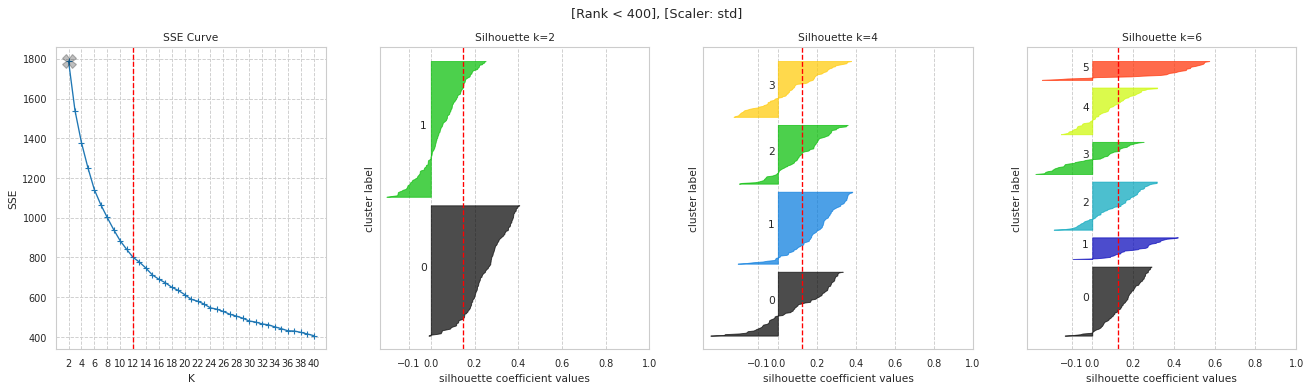

Threshold=600: computing... plotting curve... plotting silhouettes... 


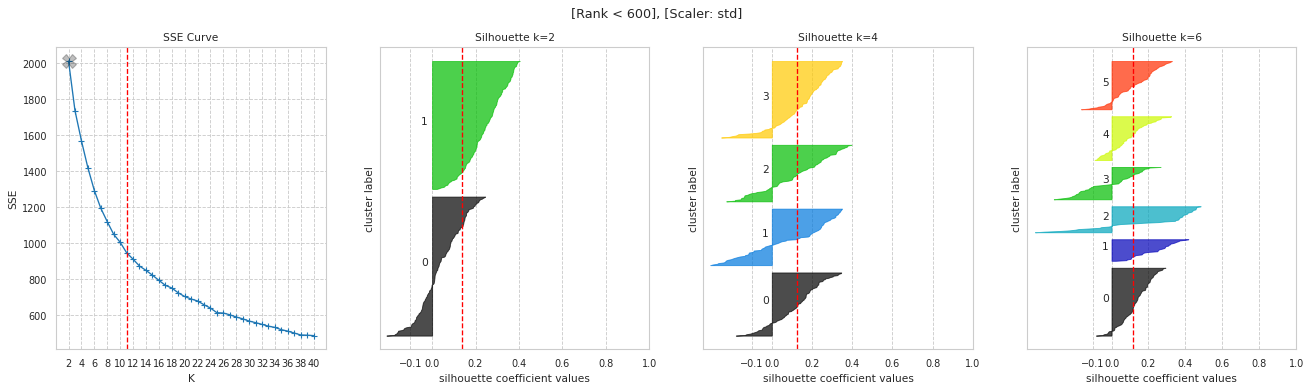

In [28]:
kmeans_xmeans_search_k(N_INIT, MAX_ITER, MAX_K, 'std', 'f', SILHOUETTE_KS)

Again, the same behaviour with k=$2$ can be observed with female players

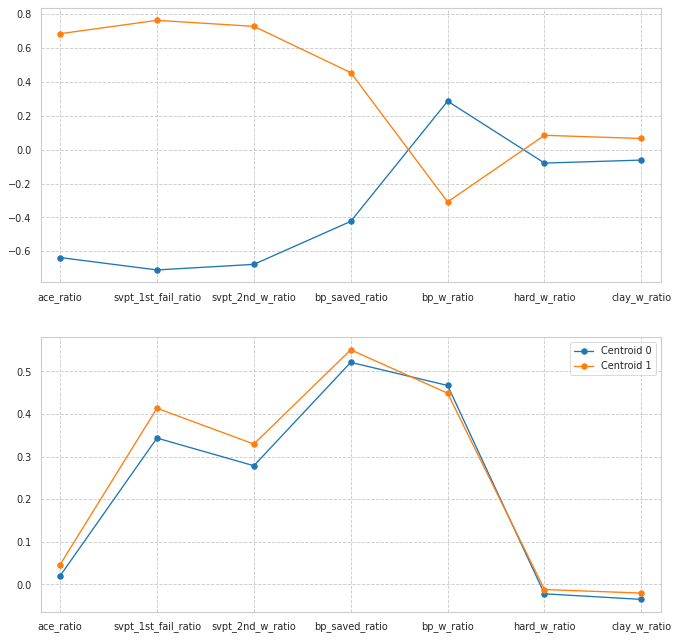

In [46]:
clustering_data = build_clustering_data(FEATURE_COLS, 600, MIN_STATS_MATCH_COUNT, 'f',  'std')
km = kmeans_clustering(clustering_data['scaled'], N_INIT, MAX_ITER, 2)

f, (a0, a1) = plt.subplots(2, 1, figsize=(10, 10))
kmeans_plot_centroids_hist(km.cluster_centers_, a0)
kmeans_plot_centroids_hist(clustering_data['scaler'].inverse_transform(km.cluster_centers_), a1)
a1.legend()

clusteringA = clustering_data['original'].copy()
clusteringA['cluster'] = km.labels_

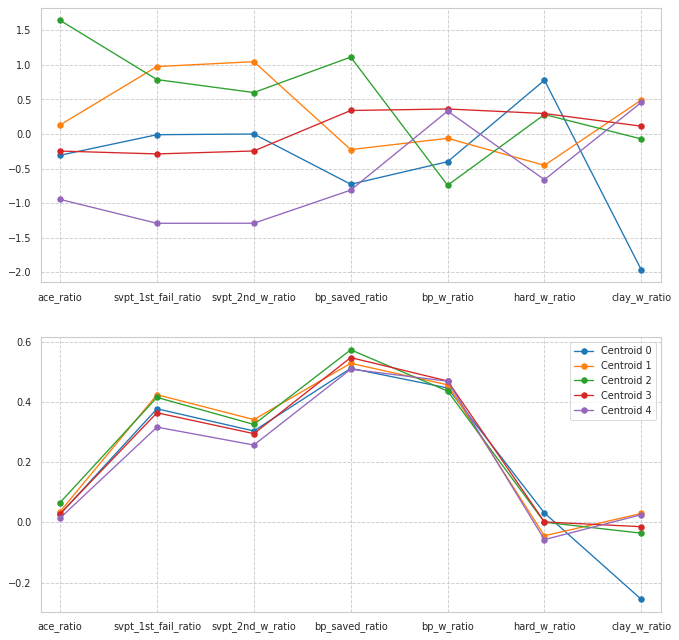

In [32]:
clustering_data = build_clustering_data(FEATURE_COLS, 600, MIN_STATS_MATCH_COUNT, 'f',  'std')
km = kmeans_clustering(clustering_data['scaled'], N_INIT, MAX_ITER, 5)

f, (a0, a1) = plt.subplots(2, 1, figsize=(10, 10))
kmeans_plot_centroids_hist(km.cluster_centers_, a0)
kmeans_plot_centroids_hist(clustering_data['scaler'].inverse_transform(km.cluster_centers_), a1)
a1.legend()

clusteringA = clustering_data['original'].copy()
clusteringA['cluster'] = km.labels_

- verdi: giocatori che se la giocano più che altro nella prima di servizio facendo gli ace. Bp saved ratio più alto perché avendo l'ace dalla propria parte riescono a salvare più breakpoints. Breakpoint vinti più bassi perché sono gli avversari a servire e non loro. Più bravi sull'hard che sul clay (poiché il cemento è una superficie veloce che avvantaggia il loro stile di gioco). Es williams, pliskova
- blu: giocatori con un servizio potente (notare l'ace piuttosto elevato), forti sul cemento e probabilmente poco agili per cui non giocano bene sulla terra. Potrebbero essere come i blu, ma son meno efficiaci (infatti contengono per lo più giocatori di "seconda fascia"). Es vinci, gasparyan
- viola: giocatori tenaci (difensivi) ed agili, che sul cemento non rendono. Es errani, stephens
- rossi: giocatori equilibrati (anche per il tipo di terreno che per loro è indifferente) e killer (pochi errori in servizio), leggermente sulla difensiva/pallettari. Es halep, kerber
- arancioni: giocatori "nervosi". Come gli arancioni, ma che nel periodo considerato non hanno giocato bene (alto tasso di errore sul servizio). Es giorgi, ostapenko

In [33]:
clusteringA = clusteringA[['cluster']].join(players)

Let's see which famous players belong to each of the five clusters:

In [35]:
clusteringA.loc[clusteringA.cluster == 0, ['cluster']].join(players[['l1_f_match_count', 'l2_f_match_count']]).sort_values(by=['l1_f_match_count', 'l2_f_match_count'], ascending=False).head(10)

,cluster,l1_f_match_count,l2_f_match_count
fullname,,,
margarita gasparyan,0,0,1
yafan wang,0,0,1
kirsten flipkens,0,0,1
roberta vinci,0,0,1
yanina wickmayer,0,0,1
kimberly birrell,0,0,0
olivia rogowska,0,0,0
danielle lao,0,0,0
vitalia diatchenko,0,0,0


In [36]:
clusteringA.loc[clusteringA.cluster == 1, ['cluster']].join(players[['l1_f_match_count', 'l2_f_match_count']]).sort_values(by=['l1_f_match_count', 'l2_f_match_count'], ascending=False).head(10)

,cluster,l1_f_match_count,l2_f_match_count
fullname,,,
jelena ostapenko,1,2,2
iga swiatek,1,2,1
kristina mladenovic,1,1,5
marketa vondrousova,1,1,0
camila giorgi,1,0,2
donna vekic,1,0,2
aleksandra krunic,1,0,1
stefanie voegele,1,0,1
ons jabeur,1,0,1


In [37]:
clusteringA.loc[clusteringA.cluster == 2, ['cluster']].join(players[['l1_f_match_count', 'l2_f_match_count']]).sort_values(by=['l1_f_match_count', 'l2_f_match_count'], ascending=False).head(10)

,cluster,l1_f_match_count,l2_f_match_count
fullname,,,
serena williams,2,10,1
karolina pliskova,2,7,11
naomi osaka,2,6,3
ashleigh barty,2,3,12
madison keys,2,3,5
kiki bertens,2,3,4
petra kvitova,2,2,9
johanna konta,2,2,3
jennifer brady,2,1,0


In [38]:
clusteringA.loc[clusteringA.cluster == 3, ['cluster']].join(players[['l1_f_match_count', 'l2_f_match_count']]).sort_values(by=['l1_f_match_count', 'l2_f_match_count'], ascending=False).head(10)

,cluster,l1_f_match_count,l2_f_match_count
fullname,,,
simona halep,3,12,5
angelique kerber,3,6,5
garbine muguruza,3,4,4
victoria azarenka,3,4,2
svetlana kuznetsova,3,3,3
caroline wozniacki,3,2,9
elina svitolina,3,2,5
bianca andreescu,3,2,2
sofia kenin,3,2,1


In [39]:
clusteringA.loc[clusteringA.cluster == 4, ['cluster']].join(players[['l1_f_match_count', 'l2_f_match_count']]).sort_values(by=['l1_f_match_count', 'l2_f_match_count'], ascending=False).head(10)

,cluster,l1_f_match_count,l2_f_match_count
fullname,,,
sloane stephens,4,3,3
darya kasatkina,4,1,5
laura siegemund,4,0,2
yulia putintseva,4,0,1
sara errani,4,0,1
kateryna kozlova,4,0,0
viktoriya tomova,4,0,0
timea bacsinszky,4,0,0
madison brengle,4,0,0
